In [1]:
# for good measure
%config Completer.use_jedi = False

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn.model_selection as model_selection
import sklearn.preprocessing as preprocessing
import sklearn.decomposition as decomposition
import sklearn.metrics as metrics

import sklearn.svm as svm
import sklearn.neighbors as neighbors
import sklearn.ensemble as ensemble
import sklearn.linear_model as linear_model
import sklearn.tree as tree
import sklearn.naive_bayes as naive_bayes

import xgboost as xgb

### Load datasets

In [3]:
test_data = pd.read_csv("data/data_set_ALL_AML_independent.csv")
train_data = pd.read_csv("data/data_set_ALL_AML_train.csv")
truth_labels = pd.read_csv("data/actual.csv")

### Cleaning data

Investigate what we see in the data and what cleaning we should perform

In [4]:
train_data.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [5]:
truth_labels.head()

,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


In [6]:
# drop all columns with "call"
test_data = test_data.drop(labels = [col for col in test_data.columns if "call" in col], axis=1)
train_data = train_data.drop(labels = [col for col in train_data.columns if "call" in col],axis=1)

# concatenate all data for all patients and get all 72 patients only
data_all = pd.concat([train_data,test_data], axis=1)[map(str, range(1,73))]
data_all = data_all.T

In [7]:
# Encoding categorical values
data_all["patient"] = pd.to_numeric(list(map(str, range(1,73))))
truth_labels["cancer"] = pd.get_dummies(truth_labels.cancer, drop_first=True)

data_all = pd.merge(data_all, truth_labels, on="patient")

In [8]:
data_all.head()

,0,1,2,3,4,5,6,7,8,9,...,7121,7122,7123,7124,7125,7126,7127,7128,patient,cancer
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,-125,389,-37,793,329,36,191,-37,1,0
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,-36,442,-17,782,295,11,76,-14,2,0
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,33,168,52,1138,777,41,228,-41,3,0
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,218,174,-110,627,170,-50,126,-91,4,0
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,57,504,-26,250,314,14,56,-25,5,0


In [9]:
data_all['cancer'].value_counts()

0    47
1    25
Name: cancer, dtype: int64

Text(0.5, 1.0, 'Class distributions')

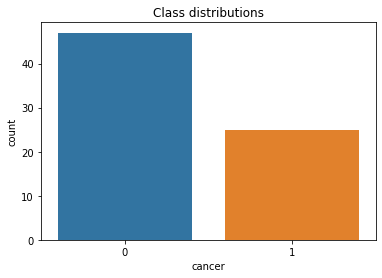

In [10]:
plt.figure()
sns.countplot(x='cancer', data=data_all)
plt.title('Class distributions')

In [11]:
# Need to balance our dataset before we can run some classification algorithms on them
# First split into train and test sets

X, y = data_all.drop(columns=['cancer']), data_all['cancer']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=0)


In [12]:
# Feature scaling 

standard_scaler_X = preprocessing.StandardScaler()
X_train = standard_scaler_X.fit_transform(X_train)
X_test = standard_scaler_X.transform(X_test)

<AxesSubplot:ylabel='Density'>

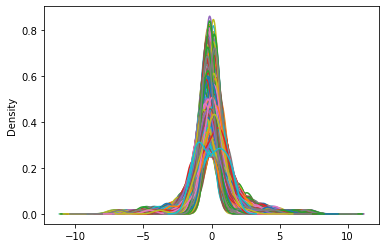

In [13]:
df_X_train = pd.DataFrame(X_train)
df_X_train.plot(kind='kde', legend=None)

### Dimensionality reduction using PCA

We have a few thousands of features. Do we really need all of them, or can we get rid of some.

<BarContainer object of 52 artists>

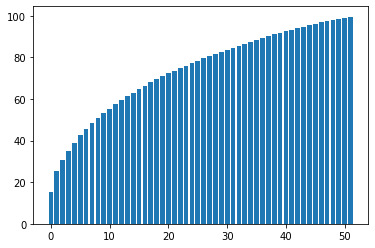

In [14]:
# check how many features we need to explain 99% of the variance

pca = decomposition.PCA()
pca.fit_transform(X_train)

k, curr_var, total_var = 0, 0, sum(pca.explained_variance_)
while curr_var/total_var < 0.99:
    curr_var += pca.explained_variance_[k]
    k += 1

pca = decomposition.PCA(n_components = k)
X_train_pca = pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

explained_var = pca.explained_variance_ratio_.cumsum() * 100
plt.bar(range(k), explained_var)

In [15]:
# balancing our labels by oversampling with the synthetic oversampling technique

from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
import collections

print("Before upsampling: ")
print(collections.Counter(y_train))

oversample = SMOTE()
X_train_ov, y_train_ov = oversample.fit_resample(X_train_pca, y_train)

print("After upsampling: ")
print(collections.Counter(y_train_ov))

Before upsampling: 
Counter({0: 39, 1: 15})
After upsampling: 
Counter({0: 39, 1: 39})


## Support Vector Machine

Do some quick hyperparameter optimization

In [16]:
# optimize by searching through a grid

svc_params = [
    {'C' : [1, 10, 100, 1000], 'kernel': ['linear']},
    {'C' : [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [i/10.0 for i in range(1,10)]},
]

search = model_selection.GridSearchCV(svm.SVC(), svc_params, n_jobs=-1, verbose=1)
search.fit(X_train_ov, y_train_ov)

best_accuracy = search.best_score_
best_params = search.best_params_
best_svc = search.best_estimator_
best_svc

Fitting 5 folds for each of 40 candidates, totalling 200 fits


SVC(C=1, kernel='linear')

In [17]:
# build the actual SVM
 
svc_model= svm.SVC(C=1, kernel='linear', probability=True)

svc_model.fit(X_train_ov, y_train_ov)

SVC(C=1, kernel='linear', probability=True)

In [61]:

prediction = svc_model.predict(X_test_pca)
acc_svc = metrics.accuracy_score(prediction,y_test)
print('The accruacy of the SVM is: ', acc_svc)
print('Classification report:\n', metrics.classification_report(y_test,prediction))

The accruacy of the SVM is:  0.8888888888888888
Classification report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.80      0.89        10

    accuracy                           0.89        18
   macro avg       0.90      0.90      0.89        18
weighted avg       0.91      0.89      0.89        18



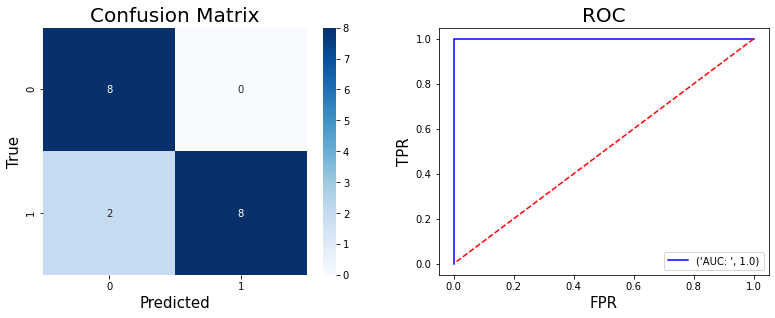

In [64]:
# plot the confusion matrix

def plot_confusion_matrix(prediction):
    plt.figure(figsize=(13,10))
    plt.subplot(221)
    sns.heatmap(metrics.confusion_matrix(y_test, prediction), annot=True, cmap='Blues', fmt='d')
    plt.title('Confusion Matrix', fontsize=20)
    plt.xlabel('Predicted', fontsize=15)
    plt.ylabel('True', fontsize=15)


def plot_roc_curve(model):
    predicting_probabilities = model.predict_proba(X_test_pca)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test,predicting_probabilities)
    plt.subplot(222)
    plt.plot(fpr,tpr, label=('AUC: ',metrics.auc(fpr,tpr)), color='b')
    plt.plot([1,0],[1,0], linestyle='dashed', color='r')
    plt.legend(loc='best')
    plt.title('ROC', fontsize=20)
    plt.xlabel('FPR', fontsize=15)
    plt.ylabel('TPR', fontsize=15)

plot_confusion_matrix(prediction)
plot_roc_curve(svc_model)


## KNN

Spin up quick KNN algorithm to have a go at this

In [34]:
# Hyperparameter optimisation

knn_param = {
    'n_neighbors' : [i for i in range(1,50,5)],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [1, 10, 30, 50],
    'p': [1, 2],
}
search = model_selection.GridSearchCV(neighbors.KNeighborsClassifier(), knn_param, n_jobs=-1, verbose=1)
search.fit(X_train_ov, y_train_ov)

best_accuracy = search.best_score_
best_params = search.best_params_
best_knn = search.best_estimator_
best_knn


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, n_neighbors=1)

In [35]:
# Create and fit the model

knn_model = neighbors.KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, n_neighbors=1, weights='distance')
knn_model.fit(X_train_ov,y_train_ov)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, n_neighbors=1,
                     weights='distance')

In [36]:

prediction = knn_model.predict(X_test_pca)
acc_knn = metrics.accuracy_score(prediction, y_test)

print('The accruacy of KNN is: ', acc_knn)
print('Classification report:\n', metrics.classification_report(y_test,prediction))

The accruacy of the SVM is:  0.6666666666666666
Classification report:
               precision    recall  f1-score   support

           0       0.62      0.62      0.62         8
           1       0.70      0.70      0.70        10

    accuracy                           0.67        18
   macro avg       0.66      0.66      0.66        18
weighted avg       0.67      0.67      0.67        18



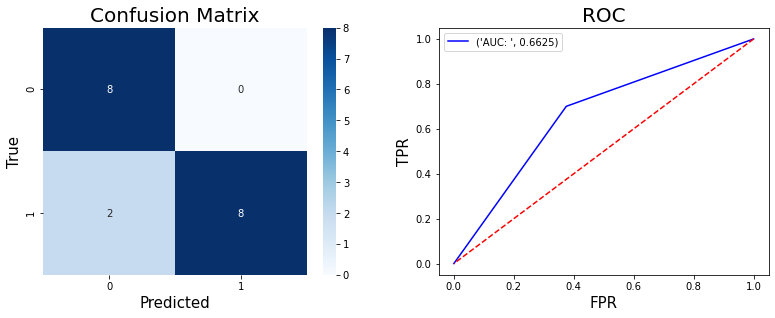

In [65]:
# Confusion matrix

plot_confusion_matrix(prediction)
plot_roc_curve(knn_model)


## Logistic regression

In [53]:
# Hyperparameter optimisation
import warnings; warnings.simplefilter('ignore') # l1_ratio only really makes sense for elasticnet

log_params = {
    "C": [1e-04, 1e-03, 1e-02, 1e-01, 1, 10, 100],
    "penalty": ["l1", "l2", "elasticnet"],
    "l1_ratio": [0.2,0.4,0.5,0.6,0.8]
}

log_model = model_selection.GridSearchCV(
    linear_model.LogisticRegression(solver="saga"),
    param_grid=log_params,
    cv=3,
    scoring="accuracy",
)

log_model.fit(X_train_ov,y_train_ov)

best_acc = log_model.best_score_
best_params = log_model.best_params_
best_log = log_model.best_estimator_
best_log

LogisticRegression(C=0.01, l1_ratio=0.4, penalty='elasticnet', solver='saga')

In [54]:
log_model = linear_model.LogisticRegression(C=0.01, l1_ratio=0.4, penalty='elasticnet', solver='saga')
log_model.fit(X_train_ov,y_train_ov)

LogisticRegression(C=0.01, l1_ratio=0.4, penalty='elasticnet', solver='saga')

In [55]:
prediction = log_model.predict(X_test_pca)
acc_log = metrics.accuracy_score(prediction, y_test)

print('The accuracy of the logistic regression is: ', acc_log)
print('Classification report:\n', metrics.classification_report(y_test,prediction))

The accruacy of the logistic regression is:  0.7777777777777778
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.71      1.00      0.83        10

    accuracy                           0.78        18
   macro avg       0.86      0.75      0.75        18
weighted avg       0.84      0.78      0.76        18



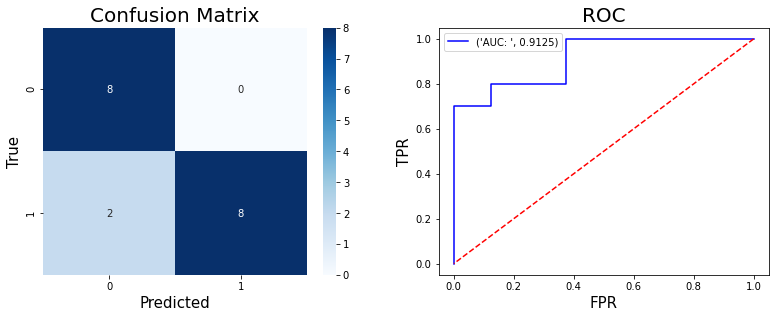

In [66]:
plot_confusion_matrix(prediction)
plot_roc_curve(log_model)

## Decision trees

In [57]:
tree_params = {
    'max_leaf_nodes': list(range(2, 100)),
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9], 
    'max_depth':[2, 3, 4, 5, 6, 7, 8, 9]
}

tree_model = model_selection.GridSearchCV(
    tree.DecisionTreeClassifier(random_state=42),
    param_grid=tree_params,
    cv=3,
    verbose=1,
)

tree_model.fit(X_train_ov,y_train_ov)

best_acc = tree_model.best_score_
best_params = tree_model.best_params_
best_tree = tree_model.best_estimator_
best_tree

Fitting 3 folds for each of 6272 candidates, totalling 18816 fits


DecisionTreeClassifier(max_depth=2, max_leaf_nodes=4, random_state=42)

In [58]:
tree_model = tree.DecisionTreeClassifier(max_depth=2, max_leaf_nodes=4, random_state=42)
tree_model.fit(X_train_ov, y_train_ov)

DecisionTreeClassifier(max_depth=2, max_leaf_nodes=4, random_state=42)

In [68]:
prediction = tree_model.predict(X_test_pca)
acc_tree = metrics.accuracy_score(prediction, y_test)

print('The validation accuracy of the decision tree is: ', acc_tree)
print('Classification report:\n', metrics.classification_report(y_test,prediction))

The validation accuracy of the decision tree is:  0.7222222222222222
Classification report:
               precision    recall  f1-score   support

           0       0.62      1.00      0.76         8
           1       1.00      0.50      0.67        10

    accuracy                           0.72        18
   macro avg       0.81      0.75      0.71        18
weighted avg       0.83      0.72      0.71        18



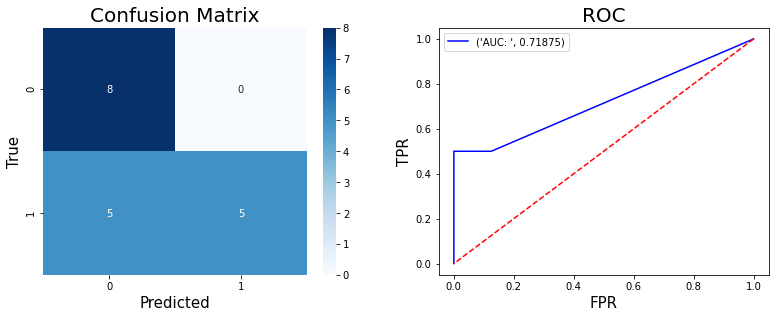

In [69]:
plot_confusion_matrix(prediction)
plot_roc_curve(tree_model)

## Random forest

The next logical step after the decision tree ...

In [72]:
# Hyperparameter optimisation

forest_params = {
    'bootstrap': [False, True],
    'n_estimators': [60, 80, 100, 120, 150],
    'max_features': [0.5, 0.6, 0.65, 0.7, 0.75, 0.8],
    'min_samples_leaf': [6, 8, 10, 12, 14],
    'min_samples_split': [2, 3, 5, 7]
}

forest_model = model_selection.GridSearchCV(estimator=ensemble.RandomForestClassifier(), param_grid=forest_params, cv=3, scoring='accuracy')
forest_model.fit(X_train_ov, y_train_ov)

best_acc = forest_model.best_score_
best_params = forest_model.best_params_
best_forest = forest_model.best_estimator_
best_forest

RandomForestClassifier(max_features=0.5, min_samples_leaf=6,
                       min_samples_split=7, n_estimators=60)

In [73]:
forest_model = ensemble.RandomForestClassifier(
    max_features=0.5, min_samples_leaf=6, min_samples_split=7, n_estimators=60
)
forest_model.fit(X_train_ov, y_train_ov)

RandomForestClassifier(max_features=0.5, min_samples_leaf=6,
                       min_samples_split=7, n_estimators=60)

In [74]:
prediction = forest_model.predict(X_test_pca)
acc_forest = metrics.accuracy_score(prediction, y_test)

print('The validation accuracy of the random forest is: ', acc_forest)
print('Classification report:\n', metrics.classification_report(y_test,prediction))

The validation accuracy of the random forest is:  0.7777777777777778
Classification report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         8
           1       1.00      0.60      0.75        10

    accuracy                           0.78        18
   macro avg       0.83      0.80      0.77        18
weighted avg       0.85      0.78      0.77        18



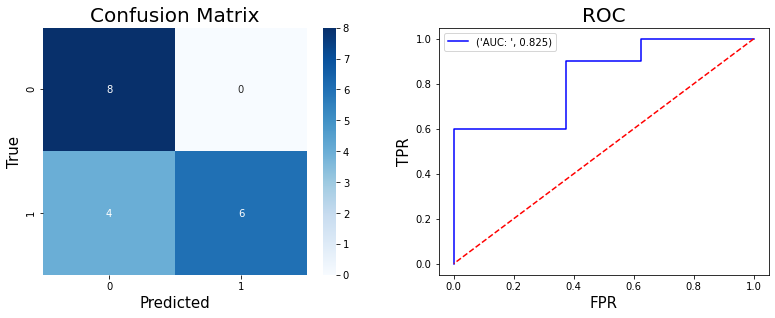

In [75]:
plot_confusion_matrix(prediction)
plot_roc_curve(forest_model)

## XGBoost

In [81]:
# Hyperparameter optimisation

xgb_grid_params = {
    'max_depth': [3, 4, 5, 6, 7, 8, 10, 12],
    'min_child_weight': [1, 2, 4, 6, 8, 10, 12, 15],
    'n_estimators': [40, 50, 60, 70, 80, 90, 100, 110, 120, 130],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
}

xgb_model = model_selection.GridSearchCV(estimator=xgb.XGBClassifier(eval_metric='logloss'), param_grid=xgb_grid_params, cv=3, scoring='accuracy')
xgb_model.fit(X_train_ov, y_train_ov)

best_acc = xgb_model.best_score_
best_params = xgb_model.best_params_
best_xgb = xgb_model.best_estimator_
best_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=40, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [84]:
xgb_model = xgb.XGBClassifier(
    base_score=0.5, booster='gbtree', colsample_bylevel=1,
    colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
    gamma=0, gpu_id=-1, importance_type='gain',
    interaction_constraints='', learning_rate=0.2, max_delta_step=0,
    max_depth=3, min_child_weight=1, missing=None,
    monotone_constraints='()', n_estimators=40, n_jobs=4,
    num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
    scale_pos_weight=1, subsample=1, tree_method='exact',
    validate_parameters=1, verbosity=None
)
xgb_model.fit(X_train_ov, y_train_ov)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None,
              monotone_constraints='()', n_estimators=40, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [85]:
prediction = xgb_model.predict(X_test_pca)
acc_xgb = metrics.accuracy_score(prediction, y_test)

print('The validation accuracy of XGBoost: ', acc_xgb)
print('Classification report:\n', metrics.classification_report(y_test,prediction))

The validation accuracy of XGBoost:  0.7222222222222222
Classification report:
               precision    recall  f1-score   support

           0       0.62      1.00      0.76         8
           1       1.00      0.50      0.67        10

    accuracy                           0.72        18
   macro avg       0.81      0.75      0.71        18
weighted avg       0.83      0.72      0.71        18



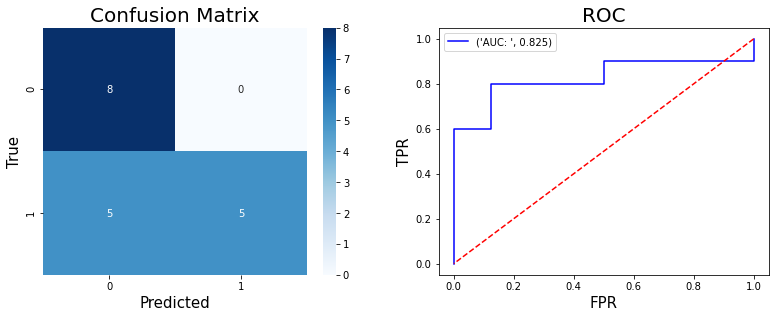

In [86]:
plot_confusion_matrix(prediction)
plot_roc_curve(xgb_model)

## Naive Bayes

Finally, naive bayes, the last I'll try (and probably one of the best for this problem)

In [91]:
nb_model = naive_bayes.GaussianNB()
nb_model.fit(X_train_ov, y_train_ov)

GaussianNB()

In [92]:
prediction = nb_model.predict(X_test_pca)
acc_nb = metrics.accuracy_score(prediction, y_test)

print('The validation accuracy of Gaussian Naive Bayes: ', acc_nb)
print('Classification report:\n', metrics.classification_report(y_test,prediction))

The validation accuracy of Gaussian Naive Bayes:  0.7777777777777778
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.71      1.00      0.83        10

    accuracy                           0.78        18
   macro avg       0.86      0.75      0.75        18
weighted avg       0.84      0.78      0.76        18



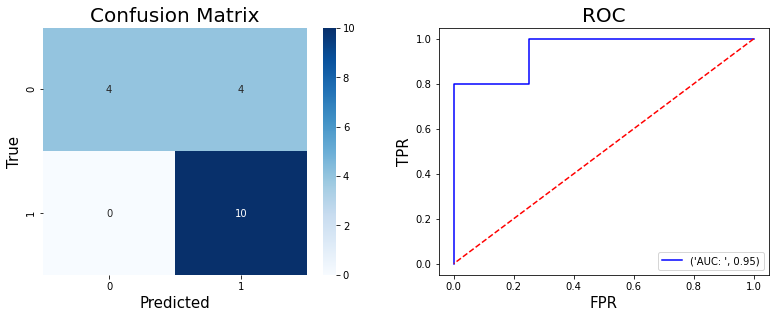

In [93]:
plot_confusion_matrix(prediction)
plot_roc_curve(nb_model)

## Model Evaluation

We'll compare the performance of each model here.

In [94]:
models = pd.DataFrame({
    'Model': ['SVM', 'KNN', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'Naive Bayes'],
    'Score': [acc_svc, acc_knn, acc_log, acc_tree, acc_forest, acc_xgb, acc_nb]
})
models.sort_values(by='Score', ascending=False)

,Model,Score
0,SVM,0.888889
2,Logistic Regression,0.777778
4,Random Forest,0.777778
6,Naive Bayes,0.777778
3,Decision Tree,0.722222
5,XGBoost,0.722222
1,KNN,0.666667
